In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import os
import shinrl as srl
import seaborn as sns

In [2]:
# use pretrained data in ./results if False
run_experiments = True

# Figure 1. Analyzing DQL Results on MountainCar using ShinRL.

In [3]:
env_config = srl.MountainCar.DefaultConfig()
env = srl.MountainCar()

/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [4]:
# delete existing results
path = "./results/dqn"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)

In [5]:
config = srl.DiscreteViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy", 
    eps_decay=5000,
    eps_end=0.05,
    target_update_interval=100,
    steps_per_epoch=100000
)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
dqn = srl.DiscreteViSolver.factory(env, config, mixins)

2021-12-01T06:38:06.699548Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': <EXPLORE.eps_greedy: 2>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 0.0, 'kl_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'eps_end': 0.05, 'eps_warmup': 0, 'eps_decay': 5000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'loss_fn': <LOSS.l2_loss: 5>} env_id=None solver_id=MixedSolver-0
2021-12-01T06:38:07.115018Z set_env is called.             env_id=0 solver_id=MixedSolver-0
2021-12-01T06:38:07.116886Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_history', 'Deep

In [6]:
if run_experiments:
    dqn.run()
    dqn.save(path)

Epoch 0:   0%|                   | 0/100000 [00:00<?, ?it/s]/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
Epoch 0: 100%|█████| 100000/100000 [02:22<00:00, 703.10it/s]
2021-12-01T06:40:30.167090Z Epoch 1 has ended.             env_id=0 epoch_summary={'Return': {'Average': -26.003, 'Max': -11.25, 'Min': -200.0}, 'Loss': {'Average': 0.14590180621208856, 'Max': 5.3018479347229, 'Min': 0.00024733098689466715}} prms_dict=['QNet', 'TargQNet', 'QOpt'] solver_id=MixedSolver-0 tb_dict=['Q', 'ExplorePolicy', 'ExploitPolicy']
2021-12-01T06:40:30.174074Z Histories a

In [7]:
dqn.load("./results/dqn/")

2021-12-01T06:40:30.187644Z Load histories.                dir_path=./results/dqn/ env_id=0 solver_id=MixedSolver-0


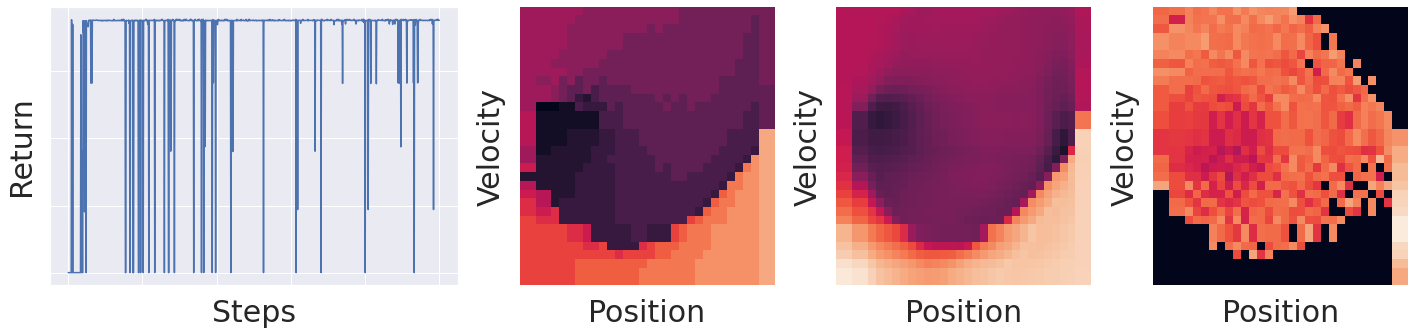

In [8]:
# plot return

performance = dqn.scalars["Return"]

# plot optimal Q values
v = env.calc_optimal_q()[:, -1] 
lv = dqn.tb_dict["Q"][:, -1] 
vmin, vmax = min(v.min(), lv.min()), max(v.max(), lv.max())

grid_kws = {"width_ratios": (0.4, 0.25, 0.25, 0.25)}
import seaborn as sns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), gridspec_kw=grid_kws)


axes[0].plot(performance["x"], performance["y"])
axes[0].set_xlabel("Steps", fontsize=30)
axes[0].set_xticklabels([])
axes[0].set_ylabel("Return", fontsize=30)
axes[0].set_yticklabels([])

env.plot_S(v, ax=axes[1], cbar_ax=None, vmin=vmin, vmax=vmax, fontsize=30)
env.plot_S(lv, ax=axes[2], cbar_ax=None, vmin=vmin, vmax=vmax, fontsize=30)

# plot learnd Q values
from matplotlib.colors import LogNorm
pol = dqn.tb_dict["ExplorePolicy"]
visit = env.calc_visit(pol).sum(axis=1) + 1e-30

env.plot_S(visit, ax=axes[3], fontsize=30, norm=LogNorm())


for i in range(1, 4):
    axes[i].set_xlabel("Position")
    axes[i].set_xticklabels([])
    axes[i].set_ylabel("Velocity")
    axes[i].set_yticklabels([])
fig.tight_layout()
plt.savefig("./results/return_Q_visit.svg", format="svg")

# Figure 3. Comparison of DQL with Different Settings on ShinMountainCar.

In [9]:
path = "./results/poor_dqn"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)
config = srl.DiscreteViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    eps_decay=1,
    eps_end=0.0,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
poor_dqn = srl.DiscreteViSolver.factory(env, config, mixins)
if run_experiments:
    poor_dqn.run()
    poor_dqn.save(path)

    
path = "./results/better_dqn"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)   
config = srl.DiscreteViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    eps_decay=1,
    eps_end=0.1,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
better_dqn = srl.DiscreteViSolver.factory(env, config, mixins)
if run_experiments:
    better_dqn.run()
    better_dqn.save(path)

    
path = "./results/ddqn/"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)   
config = srl.DiscreteViSolver.DefaultConfig(
    approx="nn",
    explore="eps_greedy",
    eps_decay=1,
    eps_end=0.1,
    eps_warmup=0,
    target_update_interval=100,
    steps_per_epoch=100000,
    use_double_q=True,
)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
ddqn = srl.DiscreteViSolver.factory(env, config, mixins)
if run_experiments:
    ddqn.run()
    ddqn.save(path)

2021-12-01T06:41:32.622670Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 100000, 'explore': <EXPLORE.eps_greedy: 2>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 0.0, 'kl_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'eps_end': 0.0, 'eps_warmup': 0, 'eps_decay': 1, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'loss_fn': <LOSS.l2_loss: 5>} env_id=None solver_id=MixedSolver-1
2021-12-01T06:41:32.623729Z set_env is called.             env_id=0 solver_id=MixedSolver-1
2021-12-01T06:41:32.625541Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_history', 'DeepRlSt

In [10]:
poor_dqn.load("./results/poor_dqn/")
better_dqn.load("./results/better_dqn/")
ddqn.load("./results/ddqn/")

2021-12-01T06:48:36.164057Z Load histories.                dir_path=./results/poor_dqn/ env_id=0 solver_id=MixedSolver-1
2021-12-01T06:48:36.174302Z Load histories.                dir_path=./results/better_dqn/ env_id=0 solver_id=MixedSolver-2
2021-12-01T06:48:36.184862Z Load histories.                dir_path=./results/ddqn/ env_id=0 solver_id=MixedSolver-3


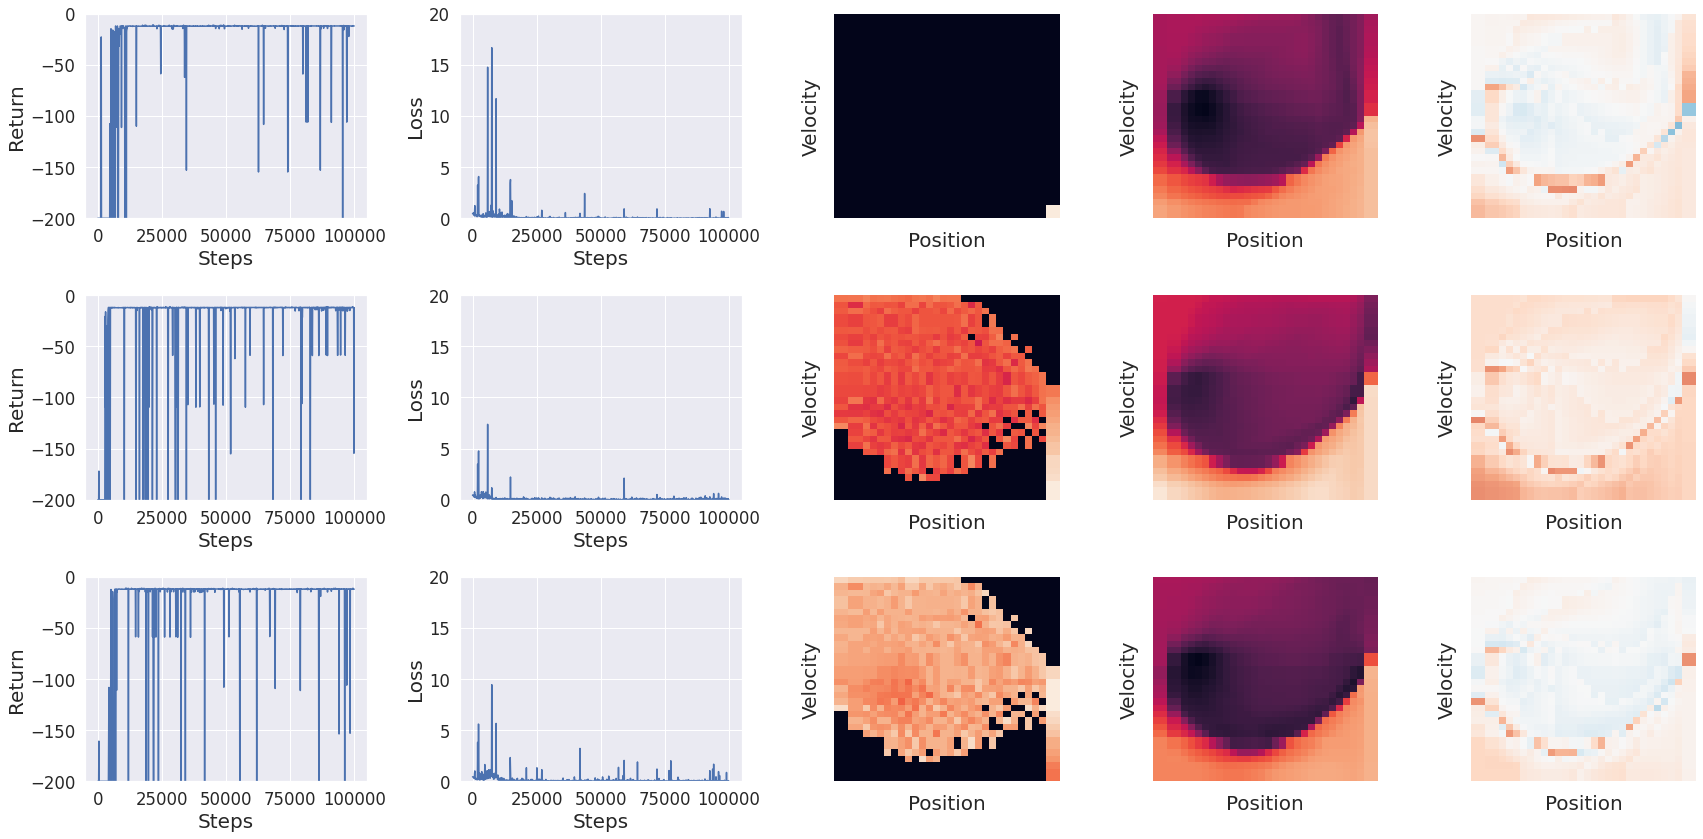

In [11]:
grid_kws = {"width_ratios": (0.25, 0.25, 0.2, 0.2, 0.2)}

import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(24, 12), gridspec_kw=grid_kws)
v = env.calc_optimal_q()[:, -1]  # dSxdA == (1025, 3)
lv = np.concatenate([dqn.tb_dict["Q"][:, -1] for dqn in [poor_dqn, better_dqn, ddqn]])
vmin, vmax = min(v.min(), lv.min()), max(v.max(), lv.max())

# env.plot_S(gap, ax=axes[0], cbar_ax=axes[-1], fontsize=30, norm=SymLogNorm(10, vmin=-100, vmax=25))

for i, dqn in enumerate([poor_dqn, better_dqn, ddqn]):
    performance = dqn.scalars["Return"]
    axes[i, 0].plot(performance["x"], performance["y"])
    axes[i, 0].set_ylim([-200, 0])
    axes[i, 0].set_xlabel("Steps", fontsize=20)
    # axes[i, 0].set_xticklabels([])
    axes[i, 0].set_ylabel("Return", fontsize=20)
    # axes[i, 0].set_yticklabels([])

    
    performance = dqn.scalars["Loss"]
    axes[i, 1].plot(performance["x"], performance["y"])
    axes[i, 1].set_ylim([0, 20])
    axes[i, 1].set_xlabel("Steps", fontsize=20)
    # axes[i, 1].set_xticklabels([])
    axes[i, 1].set_ylabel("Loss", fontsize=20)
    # axes[i, 1].set_yticklabels([])

    
    
    pol = dqn.tb_dict["ExplorePolicy"]
    visit = env.calc_visit(pol).sum(axis=1) + 1e-30
    env.plot_S(visit, ax=axes[i, 2], fontsize=20, norm=LogNorm())
    
    lv = dqn.tb_dict["Q"][:, 2]
    env.plot_S(lv, ax=axes[i, 3], fontsize=20, vmin=vmin, vmax=vmax)
    
    v = env.calc_optimal_q()[:, 2]
    gap = (lv - v) # * (visit > 1e-30)
    env.plot_S(gap, ax=axes[i, 4], fontsize=20, cmap='RdBu_r', norm=SymLogNorm(5, vmin=-200, vmax=200))
    
    for j in range(2, 5):
        axes[i, j].set_xlabel("Position")
        axes[i, j].set_xticklabels([])
        axes[i, j].set_ylabel("Velocity")
        axes[i, j].set_yticklabels([])
        
plt.tight_layout()
plt.savefig("results/case_study_1.svg", format="svg")

# Case Study2: Comparing VI, KL-regularized VI, CVI, and Munchausen DQN with ShinRL

In [4]:
import jax.numpy as jnp
import jax
import functools


class ErrorMixIn:
    @functools.partial(jax.jit, static_argnums=(0,))
    def make_noise(self, key, target):
        new_key, key = jax.random.split(key)
        noise = jax.random.normal(key, shape=target.shape)
        return new_key, noise
   
    def step(self) -> None:
        q = self.tb_dict["Q"]  # SxA
        q_targ = self.target_tabular_dp(self.tb_dict)  # SxA
        self.key, noise = self.make_noise(self.key, q_targ)
        q_targ = q_targ + noise
        self.tb_dict.set("Q", q_targ)

    def evaluate(self):
        res = super().evaluate()
        pol = self.tb_dict["ExploitPolicy"]
        q_opt = self.env.calc_optimal_q()
        q = self.env.calc_q(pol)
        gap = jnp.abs(q_opt - q).max().item()
        res.update({"OptimalityGap": gap})
        return res

2021-12-06T07:11:33.342474Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1, 'add_interval': 1, 'steps_per_epoch': 150, 'explore': <EXPLORE.oracle: 1>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.tabular: 1>, 'lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 0.0, 'kl_coef': 0.0, 'logp_clip': -100000000.0, 'use_double_q': False, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 1000, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'loss_fn': <LOSS.l2_loss: 5>} env_id=None solver_id=MixedSolver-0
2021-12-06T07:11:33.561240Z set_env is called.             env_id=0 solver_id=MixedSolver-0
2021-12-06T07:11:33.562951Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'ShinExploreMixIn.collect_samples', 'ErrorMixIn.evaluate', 'History.init_history', 'TbInitMixIn

Epoch 0: 100%|██████████████████████████| 150/150 [00:00<00:00, 479.22it/s]
2021-12-06T07:11:35.297542Z Epoch 1 has ended.             env_id=0 epoch_summary={'Return': {'Average': 5.075797520652413, 'Max': 11.548670768737793, 'Min': 0.04739752039313316}, 'OptimalityGap': {'Average': 6.76531792640686, 'Max': 12.056984901428223, 'Min': 0.9136962890625}} prms_dict=[] solver_id=MixedSolver-3 tb_dict=['Q', 'ExplorePolicy', 'ExploitPolicy']


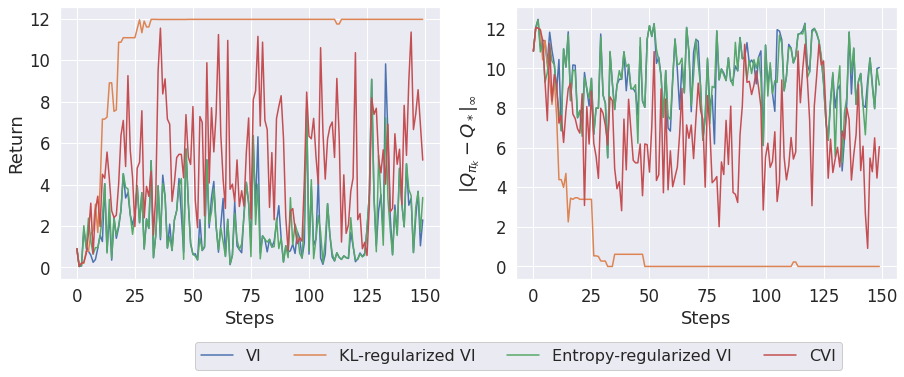

In [5]:
from shinrl import Maze
import seaborn as sns

sns.set(font_scale=1.5)

maze = Maze.str_to_maze_array("SOOO\\" + "O###\\" + "OOOO\\" + "O#RO\\")
config = Maze.DefaultConfig(eps=0.1, horizon=25)
env = Maze(maze, config)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

config = srl.DiscreteViSolver.DefaultConfig(
    add_interval=1,
    eval_interval=1,
    approx="tabular",
    exploit="greedy",
    explore="oracle",
    seed=0,
    steps_per_epoch=150,
    er_coef=0.0,
    kl_coef=0.0

)


# Value Iteration
mixins = srl.DiscreteViSolver.make_mixins(env, config)
solver = srl.DiscreteViSolver.factory(env, config, mixins=[ErrorMixIn, *mixins])
solver.run()
gap = solver.scalars["OptimalityGap"]
ret = solver.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=f"VI")

# Munchausen
config.update({"kl_coef": 1.0, "er_coef": 0.0}) 
mixins = srl.DiscreteViSolver.make_mixins(env, config)
solver = srl.DiscreteViSolver.factory(env, config, mixins=[ErrorMixIn, *mixins])
solver.run()
gap = solver.scalars["OptimalityGap"]
ret = solver.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"KL-regularized VI")

config.update({"kl_coef": 0.0, "er_coef": 0.5}) 
mixins = srl.DiscreteViSolver.make_mixins(env, config)
solver = srl.DiscreteViSolver.factory(env, config, mixins=[ErrorMixIn, *mixins])
solver.run()
gap = solver.scalars["OptimalityGap"]
ret = solver.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"Entropy-regularized VI")

config.update({"kl_coef": 1.0, "er_coef": 0.5}) 
mixins = srl.DiscreteViSolver.make_mixins(env, config)
solver = srl.DiscreteViSolver.factory(env, config, mixins=[ErrorMixIn, *mixins])
solver.run()
gap = solver.scalars["OptimalityGap"]
ret = solver.scalars["Return"]
axes[1].plot(gap["x"], gap["y"])
axes[0].plot(ret["x"], ret["y"], label=r"CVI")

fig.legend(loc="lower center", framealpha=1.0, fontsize=16, ncol=4, bbox_to_anchor=(0.55, -0.15))
axes[1].set_ylabel("$\|Q_{\pi_k} - Q_*\|_\infty$", fontsize=18)
axes[1].set_xlabel("Steps", fontsize=18)
axes[0].set_ylabel("Return", fontsize=18)
axes[0].set_xlabel("Steps", fontsize=18)
fig.savefig("results/CVI.svg", format="svg", bbox_inches='tight')

In [21]:
env = srl.make_minatar("breakout")

path = "./results/dqn_breakout/"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)   
config = srl.DiscreteViSolver.DefaultConfig(
    add_interval=10,
    eval_interval=1000,
    steps_per_epoch=1000000,
    approx="nn",
    explore="eps_greedy",
    exploit="greedy",
    num_samples=4,
    eps_end=0.1,
    eps_decay=10**5,
    eps_warmup=5000,
    logp_clip=-1,
    lr=2.5*1e-4,
    batch_size=32,
    buffer_size=1e5,
    optimizer="rmsprop",
    target_update_interval=1000,
    loss_fn="huber_loss",
    kl_coef=0.0,
    er_coef=0.0
)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
dqn_breakout = srl.DiscreteViSolver.factory(env, config, mixins)
if run_experiments:
    dqn_breakout.run()
    dqn_breakout.save(path)

    
path = "./results/mdqn_breakout/"
if run_experiments:
    srl.prepare_history_dir(path, delete_existing=True)   
config = srl.DiscreteViSolver.DefaultConfig(
    add_interval=10,
    eval_interval=1000,
    steps_per_epoch=1000000,
    approx="nn",
    explore="eps_greedy",
    exploit="greedy",
    num_samples=4,
    eps_end=0.1,
    eps_decay=10**5,
    eps_warmup=5000,
    logp_clip=-1,
    lr=2.5*1e-4,
    batch_size=32,
    buffer_size=1e5,
    optimizer="rmsprop",
    target_update_interval=1000,
    loss_fn="huber_loss",
    kl_coef=0.027,
    er_coef=0.003
)
mixins = srl.DiscreteViSolver.make_mixins(env, config)
mdqn_breakout = srl.DiscreteViSolver.factory(env, config, mixins)
if run_experiments:
    mdqn_breakout.run()
    mdqn_breakout.save(path)

2021-12-02T06:38:15.589568Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 1000, 'add_interval': 10, 'steps_per_epoch': 1000000, 'explore': <EXPLORE.eps_greedy: 2>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'lr': 0.00025, 'num_samples': 4, 'buffer_size': 100000.0, 'batch_size': 32, 'er_coef': 0.0, 'kl_coef': 0.0, 'logp_clip': -1, 'use_double_q': False, 'eps_end': 0.1, 'eps_warmup': 5000, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 1000, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.rmsprop: 19>, 'loss_fn': <LOSS.huber_loss: 3>} env_id=None solver_id=MixedSolver-36
2021-12-02T06:38:15.590896Z set_env is called.             env_id=0 solver_id=MixedSolver-36
2021-12-02T06:38:15.592495Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'GymExploreMixIn.collect_samples', 'GymEvalMixIn.evaluate', 'History.init_history', 

In [22]:
dqn_breakout.load("./results/dqn_breakout/")
mdqn_breakout.load("./results/mdqn_breakout/")

2021-12-02T07:37:30.317838Z Load histories.                dir_path=./results/dqn_breakout/ env_id=0 solver_id=MixedSolver-36
2021-12-02T07:37:30.725799Z Load histories.                dir_path=./results/mdqn_breakout/ env_id=0 solver_id=MixedSolver-37


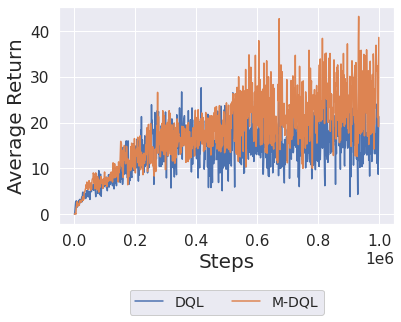

In [23]:
sns.set(font_scale=1.4)
performance = dqn_breakout.scalars["Return"]
plt.plot(performance["x"], performance["y"], label=f"DQL")
performance = mdqn_breakout.scalars["Return"]
plt.plot(performance["x"], performance["y"], label=f"M-DQL")
plt.ylabel("Average Return", fontsize=20)
plt.xlabel("Steps", fontsize=20)
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
plt.legend(loc="lower center", framealpha=1.0, fontsize=14, ncol=2, bbox_to_anchor=(0.5, -0.45))
plt.savefig("./results/Breakout.svg", bbox_inches='tight')

# Case Study3: Evaluating Poliycy Iteration and Actor Critic

In [3]:
import jax
import jax.numpy as jnp
import functools
import gym
import os

In [16]:
env = gym.make("ShinPendulum-v0")
path = "./results"

class NoiseMixIn:
    @functools.partial(jax.jit, static_argnums=(0,))
    def make_noise(self, key, rew):
        key, new_key = jax.random.split(key)
        noise = 4.9 + 0.1 * jax.random.normal(key, shape=rew.shape)
        noise = jnp.where(rew < -5, noise, 0)
        return new_key, noise
    
    def calc_params(self, prms_dict, samples):
        self.key, noise = self.make_noise(self.key, samples.rew)
        samples = samples._replace(rew=samples.rew + noise)
        return super().calc_params(prms_dict, samples)

config = srl.DiscretePiSolver.DefaultConfig(
    approx="nn", 
    explore="softmax", 
    er_coef=0.1,
    max_tmp=0.1,
    target_update_interval=100, 
    steps_per_epoch=10000,
    add_interval=1,
    eval_interval=10,
    q_lr=1e-3,
    pol_lr=1e-3,
)

mixins = srl.DiscretePiSolver.make_mixins(env, config)

In [17]:
for er_coef in [0.0, 0.001, 0.1, 1.0]:
    label = "$\lambda=$" + str(er_coef)
    config.er_coef = er_coef
    config.max_tmp = er_coef
    mixins = srl.DiscretePiSolver.make_mixins(env, config)
    pi = srl.DiscretePiSolver.factory(env, config, [NoiseMixIn, *mixins])
    pi.run()
    if run_experiments:
        _path = os.path.join(path, label)
        srl.prepare_history_dir(_path, delete_existing=True)
        pi.save(_path)

2021-12-02T06:33:19.590257Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': <EXPLORE.softmax: 3>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'pol_lr': 0.001, 'q_lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 0.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 0.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'q_loss_fn': <LOSS.l2_loss: 5>, 'pol_loss_fn': <LOSS.cross_entropy_loss: 2>} env_id=None solver_id=MixedSolver-24
2021-12-02T06:33:19.591681Z set_env is called.             env_id=0 solver_id=MixedSolver-24
2021-12-02T06:33:19.593438Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'NoiseMixIn.calc_params', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'Histor

2021-12-02T06:34:19.120871Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': <EXPLORE.softmax: 3>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'pol_lr': 0.001, 'q_lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'q_loss_fn': <LOSS.l2_loss: 5>, 'pol_loss_fn': <LOSS.kl_loss: 4>} env_id=None solver_id=MixedSolver-27
2021-12-02T06:34:19.121782Z set_env is called.             env_id=0 solver_id=MixedSolver-27
2021-12-02T06:34:19.123488Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'NoiseMixIn.calc_params', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_hist

2021-12-02T06:34:39.328830Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': <EXPLORE.softmax: 3>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'pol_lr': 0.001, 'q_lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 1.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 1.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'q_loss_fn': <LOSS.l2_loss: 5>, 'pol_loss_fn': <LOSS.kl_loss: 4>} env_id=None solver_id=MixedSolver-28
2021-12-02T06:34:39.330908Z set_env is called.             env_id=0 solver_id=MixedSolver-28
2021-12-02T06:34:39.333177Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'NoiseMixIn.calc_params', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_hist

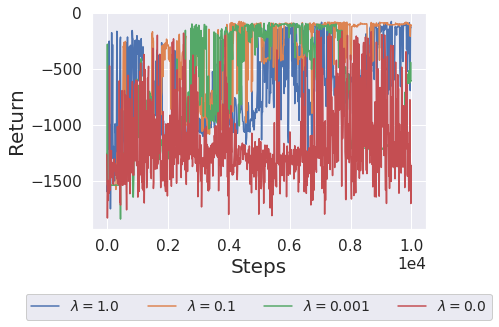

In [18]:
sns.set(font_scale=1.4)
solvers = {}
for er_coef in [1.0, 0.1, 0.001, 0.0]:
    label = "$\lambda=$" + str(er_coef)
    pi = srl.DiscretePiSolver.factory(env, config, [NoiseMixIn, *mixins])
    _path = os.path.join(path, label)
    pi.load(_path)
    solvers[label] = pi
    performance = pi.scalars["Return"]
    x, y = performance["x"], performance["y"]
    plt.plot(x, y, label=label)

plt.ylabel("Return", fontsize=20)
plt.xlabel("Steps", fontsize=20)
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
plt.legend(loc="lower center", framealpha=1.0, fontsize=14, ncol=4, bbox_to_anchor=(0.5, -0.45))
plt.savefig("./results/SAC.svg", bbox_inches='tight')

In [19]:
solvers = {}
for er_coef in [0.0, 0.001, 0.1, 1.0]:
    label = "$\lambda=$" + str(er_coef)
    config.er_coef = er_coef
    config.max_tmp = er_coef
    mixins = srl.DiscretePiSolver.make_mixins(env, config)
    pi = srl.DiscretePiSolver.factory(env, config, mixins)
    pi.run()
    solvers[label] = pi

2021-12-02T06:34:40.020318Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 10, 'add_interval': 1, 'steps_per_epoch': 10000, 'explore': <EXPLORE.softmax: 3>, 'exploit': <EXPLOIT.greedy: 2>, 'approx': <APPROX.nn: 2>, 'pol_lr': 0.001, 'q_lr': 0.001, 'num_samples': 4, 'buffer_size': 1000000, 'batch_size': 32, 'er_coef': 0.0, 'eps_end': 0.1, 'eps_warmup': 0, 'eps_decay': 100000, 'max_tmp': 0.0, 'hidden': 128, 'depth': 2, 'target_update_interval': 100, 'activation': <ACTIVATION.relu: 15>, 'optimizer': <OPTIMIZER.adam: 11>, 'q_loss_fn': <LOSS.l2_loss: 5>, 'pol_loss_fn': <LOSS.cross_entropy_loss: 2>} env_id=None solver_id=MixedSolver-32
2021-12-02T06:34:40.021898Z set_env is called.             env_id=0 solver_id=MixedSolver-32
2021-12-02T06:34:40.023711Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_history', 'DeepRlSt

2021-12-02T06:35:39.398938Z set_env is called.             env_id=0 solver_id=MixedSolver-35
2021-12-02T06:35:39.400697Z Solver is initialized.         env_id=0 methods=['Solver.__init__', 'History.add_scalar', 'ShinExploreMixIn.collect_samples', 'ShinEvalMixIn.evaluate', 'History.init_history', 'DeepRlStepMixIn.initialize', 'History.load', 'NetActMixIn.make_exploit_act', 'NetActMixIn.make_explore_act', 'History.recent_summary', 'Solver.run', 'History.save', 'Solver.seed', 'History.set_config', 'Solver.set_env', 'DeepRlStepMixIn.step', 'SoftQTargetMixIn.target_pol_dist', 'SoftQTargetMixIn.target_q_deep_dp', 'SoftQTargetMixIn.target_q_deep_rl', 'SoftQTargetMixIn.target_q_tabular_dp', 'SoftQTargetMixIn.target_q_tabular_rl'] mixins=['DeepRlStepMixIn', 'SoftQTargetMixIn', 'TargetMixIn', 'TbInitMixIn', 'NetActMixIn', 'NetInitMixIn', 'ShinExploreMixIn', 'ShinEvalMixIn'] solver_id=MixedSolver-35
Epoch 0: 100%|█████████████████| 10000/10000 [00:19<00:00, 505.69it/s]
2021-12-02T06:35:59.209455Z

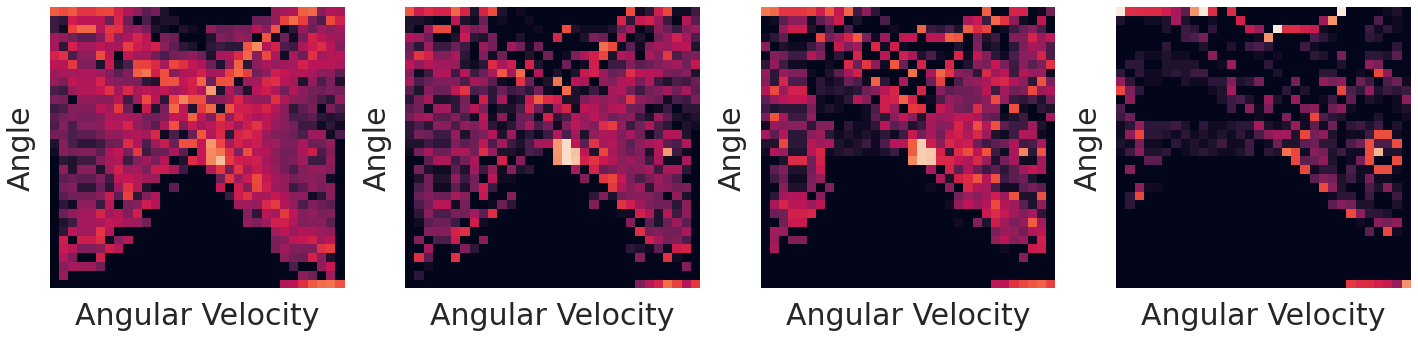

In [20]:
# plot learnd Q values
from matplotlib.colors import LogNorm, SymLogNorm
grid_kws = {"width_ratios": (0.25, 0.25, 0.25, 0.25)}
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), gridspec_kw=grid_kws)

vmax = 0
for i, er_coef in enumerate([1.0, 0.1, 0.001, 0.0]):
    label = "$\lambda=$" + str(er_coef)
    visit = env.count_visit(solvers[label].buffer).sum(1)
    vmax = visit.max()
    
for i, er_coef in enumerate([1.0, 0.1, 0.001, 0.0]):
    label = "$\lambda=$" + str(er_coef)
    visit = env.count_visit(solvers[label].buffer).sum(1) / vmax
    env.plot_S(visit, ax=axes[i], fontsize=30, vmin=0, vmax=1.0, norm=SymLogNorm(0.001, vmin=0, vmax=1.0))


    
for i in range(4):
    axes[i].set_xlabel("Angular Velocity")
    axes[i].set_xticklabels([])
    axes[i].set_ylabel("Angle")
    axes[i].set_yticklabels([])
fig.tight_layout()
fig.savefig("./results/SACvisit.svg", bbox_inches='tight')